# MyAnimeList Analysis - *Oliver Rutving (s164209)*

This is a project aimed at analyzing the anime and manga social networking platform [MyAnimeList](https://myanimelist.net/) and it's users.

**NOTE: A lot of the code takes many minutes to many hours to run. Avoid running these and instead open them from a file (there are code sections that do this). The file has to be in the same directory as the notebook.**

**ALSO: Many processes take a massive around of RAM to run. The code was run on a PC with 24GB RAM so it's not guarenteed that all of the code will run with less. It's recommended that you load some of the processed data from the provided files when hinted at in the code**

# Motivation


## What is your dataset?
The data used in this analyzis is mainly based on the [Kaggle](https://www.kaggle.com/) dataset *MyAnimeList Dataset* containing information about $300k$ users, $14k$ anime and $80mil$ ratings from [MyAnimeList.net](https://myanimelist.net/).
The Kaggle dataset can be found [here](https://www.kaggle.com/azathoth42/myanimelist) (last visited 08/12/2020)

The zipped data consists of 9 dataframes (type csv), 6 of which are cleaned/filtered versions of 3 raw ones. This analyzis will focus on only the raw data

Additionally, since the dataset does not contain reviews, these have been retrieved from the unofficial MyAnimeList API: [Jikan API](https://jikan.moe/). The official [MyAnimeList API](https://myanimelist.net/apiconfig/references/api/v2) does not provide an easy way of downloading anime reviews, hence Jikan was used.

## Why did you choose this/these particular dataset(s)?

Since this project is mainly aimed at understanding users and their anime watching habits, the need for a complete dataset is high. This is because there are over $300k$ users on the platform, and the APIs mentioned only provide limited amounts of information for each call. There is no one-API-call-contains-all information about an anime/user. One has to specify the desired attribute (for example reviews) and even then there is usually a limit of 20-50 elements per call (and you would have to pick a desired page). 

While the MyAnimeList API does not have an official rate limiting, the Jikan API has a rate limiting of 2 requests per second (preferrably 4 for bulk requests). This means that retrieving just the top 20 reviews for all anime would take over 16 hours (with a rate limiting of 4 requests per second).

The Kaggle dataset contains detailed information about users, their lists, and anime. Given the API limitations, this is the obvious choice of data.


## What was your goal for the end user's experience?

The aim of this project is to provide information about:

- User watching habits and what makes an anime popular based on different parameters (release date, score, etc.)
- How (or whether) users can be separated into meaningful groups given the tags they provide to the MAL platform
- How review sentiments differ based on different parameters (review date, score, etc.)


# Basic stats. Let's understand the dataset better


There are mainly 2 different datasets used in this project, the Kaggle dataset and the reviews dataset. 

Notice that:

- The Kaggle dataset only contains information up to July 2018.

- The Reviews dataset was collected in December 2020 and contains reviews made up to that point. 


### The Kaggle dataset

#### Anime Dataframe:
The *anime* dataframe (csv) has $20$ different attributes:

*anime_id, title, title_english, title_japanese, title_synonyms, image_url, type, source, episodes, status, background, premiered, broadcast, related, producer, licensor, studio, genre, opening_theme, ending_theme*

It has information about $14.478$ anime

The dataset is made into a dictionary so that detailed information about the anime can be found at any time given just the *anime_id*

The size of the resulting dictionary is $13MB$


#### Users Dataframe:
The *users* dataframe (csv) has $17$ different attributes:

*username, user_id, user_watching, user_completed, user_onhold, user_dropped, user_plantowatch, user_days_spent_watching, gender, location, birth_date, access_rank, join_date, last_online, stats_mean_score, stats_rewatched, stats_episodes*

It has information about $302.675$ users 

The dataset is made into a dictionary so that detailed information about the user can be found at any time given just the *user_id*

The size of the resulting dictionary is $101MB$


#### Userlists Dataframe

The userlists dataframe (csv) has $11$ different attributes:

*username, anime_id, my_watched_episodes, my_start_date, my_finish_date, my_score, my_status, my_rewatching, my_rewatching_ep, my_last_updated, my_tags*

It has $80.076.112$ rows representing all anime in all users' lists. Each row is one anime in one user's list.

The *userlists* dataframe does not contain user IDs and so the user IDs from the *users* dataframe are mapped onto the *userlists* dataframe on the *usernames* column

Next, all anime that are not in the Drama genre are removed. This is because the network of anime would be too big to parse if all genres were to be included (my computer has crashed many times trying to include them all).

Unneeded columns for analysis are removed. The following $6$ columns are kept:

*user_id, anime_id, my_watched_episodes, my_score, my_status, my_tags*

Next, all rows where either *user_id* or *anime_id* is not an integer are removed (This includes empty values). This is done to make sure the information on all users and anime in the list can be identified with the dictionaries. Additionally, it will be helpful when populating the bipartite network since user-nodes can be represented by negative integeres. Thus it is possible to differentiate between users and anime in the network.

Lastly, all rows where *my_status* is not one of the official MAL statuses are removed. The official MAL statuses (with row counts) are:

- *Watching*

- *Completed*

- *On-Hold*

- *Dropped*

- *Plan To Watch*

The result is a dataframe consisting of $22.359.059$ rows

The size of the resulting dataframe is $1.31GB$


#### Using the userlists dataframe to prepare Nodes and Edges for the network

All anime ids and user ids from the *userlists* dataframe are made into separate lists. As mentioned, since the network is going to be bipartite the user IDs are made negative so that it is possible to differentiate between users and anime.

They are also made into a list of tuples representing edges between nodes. 

Some general information about the resulting network:

- Nodes:          $277.833$
- Anime Nodes :   $2.294$
- User Nodes:     $275.539$
- Links:          $22.358.833$
- Components:     $1$
- k_min:          $1$
- k_max:          $165233$
- k_median:       $58.0$
- k_mean:         $160.9516$
- p:              $0.000579$

These statistics are further explained in the network statistics section. Here, the degree distribution can also be found.

### The reviews dataset

As mentioned, the anime reviews are retrieved through the Jikan API.

A csv file is made containing every review containing attributes:

*anime_id, review_id, helpful_count, score, username, date, words, wordcount*

Since rate limit is 4 seconds, the review content is also preprocessed to limit the size of the data and to save time on "post-processing". All unique words are tokenized and counted in each review. The review content was very neat, it was only newline and carriage return symbols that needed to be removed using regular expression re.sub. Other symbols, such as comma were removed using the regular expression re.search. The words were tokenized using nltks regular expression word_tokenize and another regular expression to remove anything but words. Stopwords were imported and the tokenized words were converted to lower case. If the tokenized word was not a stopword it was added. Unique words and counts are made into separate lists and added to the dataframe.

Two other dataframes (csv) are also made, one containing information about what anime could not be found and the associated error (usually because there are no reviews or because of a 404 error), the other about what anime (reviews) have already been added to the review dataframe. The code in the notebook only retrives the top 20 reviews for each anime.





## Cleaning and preprocessing 

First of all, let's choose a genre to analyze. Analyzing the whole network would be too resource intensive, we will see why when looking at the number of edges in the network analysis. In this case, the *Drama* genre was chosen

In [13]:
#Choose a Genre (See full list here https://myanimelist.net/anime.php)
genre = "Drama"

### the Kaggle dataset:

Let's import the necessary packages for data cleaning and open the data

In [14]:
#Import packages
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from zipfile import ZipFile
import pickle

In [15]:
#Load Data
zip_file = ZipFile('archive.zip')
csv_names = zip_file.namelist()[0:3]

#### Prepare User and Anime Dictionaries 

We start with the anime dictionary:

In [16]:
anime = pd.read_csv(zip_file.open(csv_names[0]))

dict_anime = {}

for index, row in anime.iterrows():
    dict_anime[row.anime_id] = row

with open('dict_anime.pkl', 'wb') as handle:
    pickle.dump(dict_anime, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_anime = None
anime = None

And then the user dictionary:

In [17]:
users = pd.read_csv(zip_file.open(csv_names[2]))

dict_users = {}

for index, row in users.iterrows():
    dict_users[row.user_id] = row

with open('dict_users.pkl', 'wb') as handle:
    pickle.dump(dict_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

dict_users = None
users = None

#### Prepare Userlists Dataframe

Map user_ids from the *users* dataframe onto the *userlists* dataframe on the *username* column

In [18]:
userlists = pd.read_csv(zip_file.open(csv_names[1])) #4.9GB

#Get user_ids from the user dataframe
users = pd.read_csv(zip_file.open(csv_names[2])) #30MB
userlists["user_id"] = pd.merge(userlists["username"], users[["username","user_id"]], how='outer', on=['username'])["user_id"]
users = None

Remove anime that are not in the Drama genre

In [19]:
anime = pd.read_csv(zip_file.open(csv_names[0]))[["anime_id", "genre"]]
anime = anime[anime['genre'].notna()]
anime = anime[anime.genre.str.contains(genre)]

userlists = userlists[userlists['anime_id'].isin(anime.anime_id)]

anime = None

Remove rows where anime_id and/or user_id is not an integer and make sure that the status is one of MAL's offical statuses

In [20]:
#Remove Unnecessary columns and Rows in important columns (no NANs and make sure it's the right type)
userlists = userlists[["user_id","anime_id", "my_watched_episodes", "my_score", "my_status", "my_tags"]]\
                    [(userlists["anime_id"].notna()) \
                    & (userlists["anime_id"].apply(lambda x: isinstance(x,int)))
                    & (userlists["user_id"].notna()) \
                    & (userlists["user_id"].apply(lambda x: isinstance(x,int)))
                    & (userlists["my_status"].isin([1,2,3,4,6]))]

Save the dataframe

In [21]:
#Save dataframe for later use
userlists.to_pickle("df_userlists.pkl")

#### Prepare List of Nodes, Edges from the userlists dataframe

Load the resulting userlists dataframe with relevant attributes

In [10]:
#Load the dataframes
userlists = pd.read_pickle("df_userlists.pkl")[["user_id", "anime_id", "my_status"]]

Make the anime_id and user_id columns into a list of tuples representing edges between nodes and save for later use.

In [35]:
edges_all = list(zip(userlists.anime_id, -userlists.user_id))

with open('edges_all.pkl', 'wb') as fp:
    pickle.dump(edges_all, fp)

edges_all = None

Do the same, but only include edges with separated MAL official Statuses (Watching, Completed, On-Hold, Dropped, Plan-To-Watch):

In [36]:
my_status_list = ["Watching", "Completed", "On-Hold", "Dropped", "", "Plan-To-Watch"]

for i in [1,2,3,4,6]:
    userlists_filtered = userlists[userlists.my_status == i]
    edges_temp = list(zip(userlists_filtered.anime_id, -userlists_filtered.user_id))
    userlists_filtered = None
    
    with open('edges_' + my_status_list[i-1] + '.pkl', 'wb') as fp:
        pickle.dump(edges_temp, fp)
    edges_temp = None

Save a list of anime_ids and user_ids representing nodes

In [37]:
anime_list = sorted(list(set(userlists.anime_id)))

with open('nodes_anime.pkl', 'wb') as fp:
    pickle.dump(anime_list, fp)
    anime_list = None

user_list = sorted(list(set(-userlists.user_id)), reverse=True)

with open('nodes_users.pkl', 'wb') as fp:
    pickle.dump(user_list, fp)
    user_list = None

#### ----- WHEN FINISHED WITH THIS SECTION, RESET PYTHON TO FREE MEMORY FOR THE NEXT SECTION -----

In [12]:
%reset -f

### Retrieve and Preprocess Reviews:

**NOTICE: This WILL take AT LEAST 16 hours**

load necessary packages:

In [ ]:
import csv
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from zipfile import ZipFile
import json
import urllib
import time
import numpy as np
import nltk, re, pprint
from nltk import word_tokenize

Open the list of all anime to retrieve and load the already retrieved anime (reviews):

In [ ]:
#Load the data
zip = ZipFile('archive.zip')
csv_names = zip.namelist()[0]

anime = pd.read_csv(zip.open(csv_names)) #10.1MB
anime_unique = anime["anime_id"]
anime_unique = np.sort(anime_unique.unique())

Retrieve reviews of (missing) anime using the Jikan API and add them to the reviews dataframe:

**NOTICE: The code can be interrupted and continues from where it left off automatically when run again**

In [ ]:
from urllib.error import HTTPError

reviews_csv = pd.read_csv("reviews2.csv")
saved_reviews = reviews_csv.anime_id #review_id, user_id, date, review

noreviews_csv = pd.read_csv("noreviews.csv")
noreviews = noreviews_csv.anime_id

missing_anime = [x for x in anime_unique if x not in saved_reviews.values]
missing_anime = [x for x in missing_anime if x not in noreviews.values]


toRemove = nltk.corpus.stopwords.words('english') 

Ntotal_anime = len(anime_unique)
Nmissing_anime = len(missing_anime)

rate_limiting = 4 #seconds
n_total = 15000 #Total anime to be processed in this session

n = 0;
for i in missing_anime:
    start = time.time()
    
    #Insert Function here
    status = -1
    retry_count = 0
    while status != 200 and retry_count <5:
        try:
            r = urllib.request.urlopen('https://api.jikan.moe/v3/anime/' + str(i) +'/reviews/1/')
            status = r.code
        except HTTPError as err:
            status = err.code
            retry_count = retry_count + 1
            time.sleep(4)
        except:
            status = "unknown"
            retry_count = retry_count + 1
            time.sleep(4)
        retry_count = retry_count + 1
        if status!=200: time.sleep(4)
        
    if status == 200:
        response_body = json.loads(r.read())
    
    if status == 200 and len(response_body["reviews"])>=1:
        for j in range(len(response_body["reviews"])):
            #Get data
            review_data = [] #anime_id,review_id,helpful_count,score,username,date,words,wordcount
            review_data.append(i)
            review_data.append(response_body["reviews"][j]["mal_id"])
            review_data.append(response_body["reviews"][j]["helpful_count"])
            review_data.append(response_body["reviews"][j]["reviewer"]["scores"]["overall"])
            review_data.append(response_body["reviews"][j]["reviewer"]["username"])
            review_data.append(response_body["reviews"][j]["date"].split("T", 1)[0])

            content = response_body["reviews"][j]["content"]
            content = re.sub('\r', '', content)
            content = re.sub('\n', '', content)
            content = re.sub('!', '', content)
            content = re.sub('.', '', content)
            content = re.sub(',', '', content)
            content = re.sub('?', '', content)
            content = re.sub('-', '', content)

            content_tokenized = word_tokenize(content)
            content_tokenized = [t.lower() for t in content_tokenized if t not in toRemove and re.search('^[a-zA-Z]+$',t)]

            content_words = set(content_tokenized)
            content_count  = []

            for word in content_words:
                content_count.append(content_tokenized.count(word))

            review_data.append(list(content_words))
            review_data.append(content_count)

            #ADD REVIEW TO FILE
            with open('reviews2.csv','a', encoding='utf-8') as fd:
                writer = csv.writer(fd)
                writer.writerow(review_data)
    else:
        if status == 200: error = "no reviews"
        else: error = str(status)
        with open('noreviews.csv','a', encoding='utf-8') as fd:
                writer = csv.writer(fd)
                writer.writerow([i, error])
        
    
    #End Function here
    waitfor = rate_limiting - (time.time() - start)
    if waitfor <= 0: waitfor = 0
    time.sleep(waitfor)
    
    
    b = "Cell Status: Running - n=" + str(n+1) + "/" + str(n_total) + " - " \
                                    + str((Ntotal_anime-(Nmissing_anime-n+1))) + "/" + str(Ntotal_anime) + " (" \
                                    + str(round(((Ntotal_anime-(Nmissing_anime-n+1)) / Ntotal_anime)*100, 2)) \
                                    +"%) Until All Reviews Saved         "
    print (b, end="\r")
    n= n+1
    if n>=n_total: break

#end

b = "Cell Status: Finished - n=" + str(n) + "/" + str(n_total) + " - "\
                                        + str((Ntotal_anime-(Nmissing_anime-n))) + "/" + str(Ntotal_anime) + " (" \
                                        + str(round(((Ntotal_anime-(Nmissing_anime-n)) / Ntotal_anime)*100, 2)) \
                                        +"%) Until All Reviews Saved         "
print (b, end="\r")

##### ----- WHEN FINISHED WITH THIS SECTION, RESET PYTHON TO FREE MEMORY FOR THE NEXT SECTION -----

In [1]:
%reset -f

### Data cleaning and Preprocessing is now finished--------------------------------------------------------------------------------------------

## Network statistics and Visualisation:

### Preperation

Import necessary packages

In [252]:
#Import Packages
import pickle
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import math
import numpy as np
import datetime as dt
import matplotlib.dates as dates
from numpy.polynomial.polynomial import polyfit
import community as community_louvain
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import requests,  io
import csv
import nltk, re, pprint
from nltk import word_tokenize
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
import ast

Import the node/edge lists and the dictionaries

In [4]:
#Import network information
nodes_anime = pd.read_pickle("nodes_anime.pkl")
nodes_users = pd.read_pickle("nodes_users.pkl")
edges_all = pd.read_pickle("edges_all.pkl")

#Import Anime Dictionary
with open('dict_anime.pkl', 'rb') as handle:
    dict_anime = pickle.load(handle)

#Import User Dictionary
with open('dict_users.pkl', 'rb') as handle:
    dict_users = pickle.load(handle)

Populate network

In [5]:
#Populate network (Add user and anime nodes and the edges between them)
B = nx.Graph()

print("Network populating status:")
B.add_nodes_from(nodes_anime, bipartite=0); nodes_anime = None; print("Anime nodes added")
B.add_nodes_from(nodes_users, bipartite=1); nodes_users = None; print("User nodes added")
B.add_edges_from(edges_all); edges_all = None; print("All edges added")
print("Network was successfully populated and is ready to be analyzed")

Network populating status:
Anime nodes added
User nodes added
All edges added
Network was successfully populated and is ready to be analyzed


#### Function for finding basic statistics about a graph

In [6]:
#Function to get information about the network for late use 
def network_info(G):
    N = len(G.nodes) #Number of nodes
    A = len([y for x, y in G.degree if x>0]) #Number of Anime
    U = len([y for x, y in G.degree if x<0]) #Number of Users
    L = len(G.edges) #Number of links
    C = nx.number_connected_components(G) #Number of components
    if C == 1: LC = N #Number of nodes in the largest component
    else: LC = len(max(nx.connected_component_subgraphs(G), key=len).nodes)
    k = sorted([y for x, y in G.degree]) #Node degrees
    kmin = k[0] #Node with smallest degree
    kmax = k[-1] #Node with biggest degree
    kmedian = np.median(k) #Median degree
    kmean = np.mean(k) #Average degree
    p = kmean/(N-1) #Probability of two nodes being connected
    
    #Prepare dataframe to return
    header = ["N", "N_Anime", "N_Users", "L", "Components", "Largest_Component", "k_min", "k_max", "k_median", "k_mean", "p"]
    data = [[N, A, U, L, C, LC, kmin, kmax, kmedian, kmean, p]]
    
    df1 = pd.DataFrame(data, columns=header)
    
    #Prepare degree distribution dataframe
    header = ["k_min", "k_max", "k_median", "k_mean"]
    df2 = pd.DataFrame(columns=header)
    
    df2.loc["Degree"] = [kmin, kmax, kmedian, kmean]
    
    #Degree distribution for anime (degree in)
    k = sorted([y for x, y in G.degree if x>0])
    kmin = k[0]
    kmax = k[-1]
    kmedian = np.median(k)
    kmean = np.mean(k)
    
    df2.loc["Degree_In"] = [kmin, kmax, kmedian, kmean]
    
    #Degree distribution for users (degree out)
    k = sorted([y for x, y in G.degree if x<0])
    kmin = k[0]
    kmax = k[-1]
    kmedian = np.median(k)
    kmean = np.mean(k)
    
    df2.loc["Degree_Out"] = [kmin, kmax, kmedian, kmean]

    # Return Dataframes
    return df1, df2

### Network Statistics

In [7]:
gen_info, deg_info = network_info(B); print(gen_info)

        N  N_Anime  N_Users         L  Components  Largest_Component  k_min  \
0  277833     2294   275539  22358833           1             277833      1   

    k_max  k_median    k_mean         p  
0  165233      58.0  160.9516  0.000579  


As mentioned, these are the basic stats of the network. We are dealing with a network of $277833$ nodes ($2294$ anime and $275539$ users). There are $22358833$ links between the anime and the user nodes. The graph is completely connected (likely because some users have all anime in their lists as we will discover below). The smallest degree is $1$ (likely a user with only one anime in their lists). The max degree is $165233$ (The anime that most users have in their lists. An anime since users can only have up to $2294$ anime in their library). The median degree is $58.0$ and the average degree is $160.9516$. The chance of two nodes being connected is $p=0.000579$

Let's also look at some degree information for users and anime individually:

In [19]:
gen_info, deg_info = network_info(B); print(deg_info)

            k_min     k_max  k_median       k_mean
Degree        1.0  165233.0      58.0   160.951600
Degree_In     8.0  165233.0    2065.5  9746.657803
Degree_Out    1.0    2292.0      57.0    81.145802


Here, degrees-in are degrees of anime nodes. The anime with the lowest degree is in $8$ users' lists. The max degree-in is the anime that most users ($165233$) have in their lists. The median anime degree in is $2065.5$. Anime on average are in $9746.657803$ users' lists

Some users only have $1$ anime in their lists. The user with the most anime in their lists has $2292$ in their lists. The median anime in users' lists is $57$. The average number of anime that users have in their lists is $81.145802$.

Let's look at the top 10 anime that most users have in their lists

#### Top 10 most connected Anime

In [9]:
#Top 10 most Connected Anime
top10anime = sorted([(x,y) for x, y in B.degree if x>0], key=lambda v: v[1], reverse=True)[0:10]

top10anime_df = pd.DataFrame(columns=["ID","Anime","degree"])

#Sort by degree and get anime name from dictionary
n = 1
for anime in top10anime:
    top10anime_df.loc[n] = [anime[0], dict_anime[anime[0]].title ,anime[1]]
    n = n+1

print("Top 10 most connected anime:\n")
print(top10anime_df)

Top 10 most connected anime:

       ID                               Anime  degree
1    1575     Code Geass: Hangyaku no Lelouch  165233
2   16498                  Shingeki no Kyojin  157030
3    5114    Fullmetal Alchemist: Brotherhood  155453
4    6547                        Angel Beats!  154013
5     226                          Elfen Lied  150809
6    2167                             Clannad  143912
7     121                 Fullmetal Alchemist  136971
8    2904  Code Geass: Hangyaku no Lelouch R2  134634
9     199       Sen to Chihiro no Kamikakushi  132681
10     30             Neon Genesis Evangelion  120741


These are the anime that most users have in their lists

Now let's look at the top 10 users with most anime in their lists

#### Top 10 most connected Users

In [10]:
#Top 10 users with most anime in their lists
top10users = sorted([(x,y) for x, y in B.degree if x<0], key=lambda v: v[1], reverse=True)[0:10]

top10users_df = pd.DataFrame(columns=["ID","Username","degree"])

#Sort by degree and get username from dictionary
n = 1
for user in top10users:
    top10users_df.loc[n] = [-user[0], dict_users[-user[0]].username ,user[1]]
    n = n+1

print("Top 10 users with most anime in their lists:\n")
print(top10users_df)

Top 10 users with most anime in their lists:

         ID         Username degree
1   4837235  purplepinapples   2292
2    477008           Akarin   2291
3   1245229       TsukasaKei   2290
4      8669      spacecowboy   2272
5   1473077       Fuzukigami   2244
6   4676838       7o5a3-s9f0   2211
7    441467         lanblade   2202
8   4561255          uemmega   2168
9   5436401     Ginger_Otaku   2118
10   472625       Samikuchan   2105


The top 10 users have ~91.761% to ~99.999% anime in their lists. This will create problems when projecting the network onto anime nodes as this will result in an almost complete graph. Analyzing such a graph would be close to pointless which we will get into later in the tools, theory and analysis section. 

### Network Visualization

Let's have a look at how the network looks like. Visualizing the whole network would be somewhat pointless as there are $22358833$ links in the network which would result in a big orange blob with some dots in it. Let's therefore choose a root node and look at it's level 1 and level 2 neighbors

#### Choose a root

For the sake of visualization, the anime with the lowest degree has been chosen as there otherwise would be way too many links.

In [11]:
#Find the anime with the lowest degree
netmindeg_anime = sorted([(x,y) for x, y in B.degree if x>0], key=lambda v: v[1], reverse=False)[0]

print("The Anime with the Lowest Degree in the Network:")
print(dict_anime[netmindeg_anime[0]].title + " (ID: " + str(netmindeg_anime[0]) + ") ")
print("Degrees: " + str(netmindeg_anime[1]))

The Anime with the Lowest Degree in the Network:
Maki to Kanta to Jiijii to. (ID: 34342) 
Degrees: 8


#### Level 1 Neighbors

Let's have a look at the level one neighbors (of course being users since this is a bipartite network)

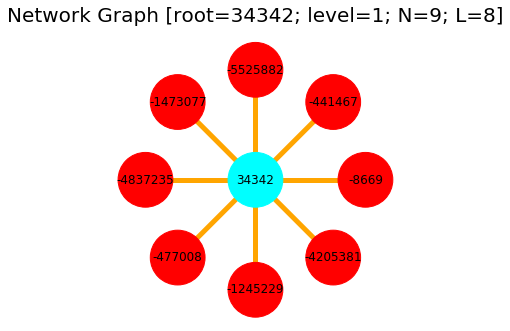

In [16]:
base = [netmindeg_anime[0]] #Root (Anime or user node ID)
depth = 1  #Depth of the search

#Search network from the root with desired depth and define the subgraph
foundset = {key for source in base for key in nx.single_source_shortest_path(B,source,cutoff=depth).keys()}
H1=B.subgraph(foundset)

#Define the max node degree to account for node size
maxdegree_user = sorted([(x,y) for x, y in H1.degree if x<0], key=lambda v: v[1], reverse=True)[0]

#Plotting variables
shells = [[],[]]
color_map = []
degree_map = []
nodeshape_map = []

for i in H1.nodes:
    if i == base[0]:
        color_map.append("cyan")
        degree_map.append(3000)
        nodeshape_map.append("v")
        shells[0].append(i)
    else:
        color_map.append("red")
        degree_map.append(H1.degree(i)/maxdegree_user[1]*3000)
        nodeshape_map.append("^")
        shells[1].append(i)

pos = nx.shell_layout(H1, shells)

#Plot the graph
plt.figure(figsize=(4,4));
plt.suptitle('Network Graph [root='+ str(base[0])+"; level="+ str(depth)+"; N=" + \
             str(len(H1.nodes))+"; L="+ str(len(H1.edges)) + "]" , fontsize=20, y=1.1)

nx.draw(H1, pos=pos ,node_color=color_map, node_size=degree_map, edge_color="orange", width=5, zoom=1,\
        node_labels = None, with_labels=True)
plt.show()

In [17]:
#Get info about the network
gen_info, deg_info = network_info(H1); print(gen_info)

   N  N_Anime  N_Users  L  Components  Largest_Component  k_min  k_max  \
0  9        1        8  8           1                  9      1      8   

   k_median    k_mean         p  
0       1.0  1.777778  0.222222  


The cyan node is the root anime and the red nodes are the 8 users who have the root anime in their lists


##### Here are the usernames of the 8 user nodes if you are curious:

In [18]:
#Usernames of the nodes found
users34342 = [(x,y) for x, y in H1.degree if x<0]
users34342_df = pd.DataFrame(columns=["Username"])

for user in users34342:
    users34342_df.loc[-user[0]] = [dict_users[-user[0]].username]

print(users34342_df)

                Username
8669         spacecowboy
441467          lanblade
5525882          mutsuto
1473077       Fuzukigami
4837235  purplepinapples
477008            Akarin
1245229       TsukasaKei
4205381      MugenDreamu


Let's now look at the network including level 2 neighbors

#### Level 2 neighbors

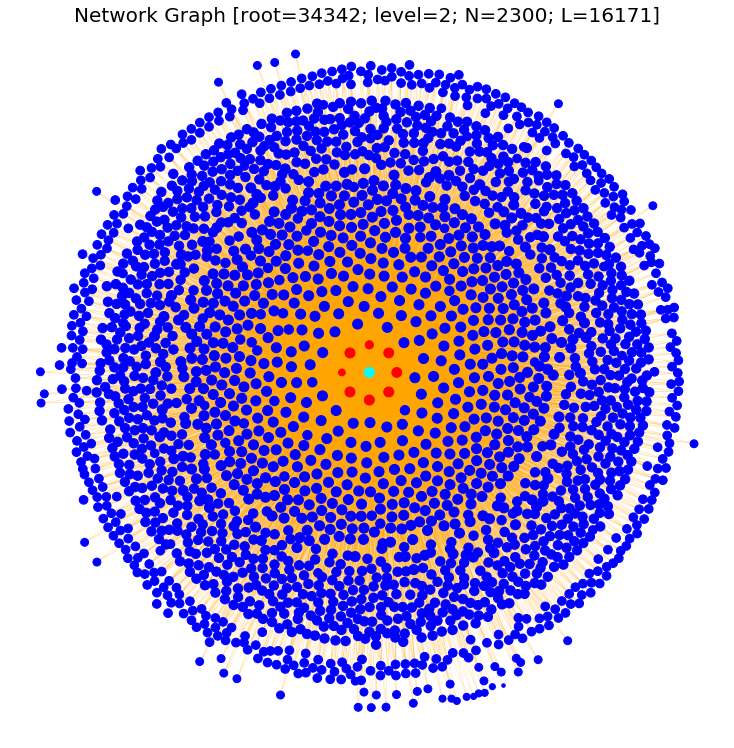

In [24]:
base = [netmindeg_anime[0]] #Root (Anime or user node ID)
depth = 2 #Depth of the search

#Search network from the root with desired depth and define the subgraph
foundset = {key for source in base for key in nx.single_source_shortest_path(B,source,cutoff=depth).keys()}
H2=B.subgraph(foundset)

#Define the max node degree to account for node size
maxdegree_user = sorted([(x,y) for x, y in H2.degree if x<0], key=lambda v: v[1], reverse=True)[0]
maxdegree_anime = sorted([(x,y) for x, y in H2.degree if x>0], key=lambda v: v[1], reverse=True)[0]

#Plotting Variables
shells = [[],[],[]]
color_map = []
degree_map = []
nodeshape_map = []

for i in H2.nodes:
    if i == base[0]:
        color_map.append("cyan")
        degree_map.append(100)
        nodeshape_map.append("v")
        shells[0].append(i)
    elif i>0:
        color_map.append("blue")
        degree_map.append(H2.degree(i)/maxdegree_anime[1]*100)
        nodeshape_map.append("^")
        shells[2].append(i)
    else:
        color_map.append("red")
        degree_map.append(H2.degree(i)/maxdegree_user[1]*100)
        nodeshape_map.append("^")
        shells[1].append(i)

#Determine appropritate positions for nodes
pos = nx.shell_layout(H2, shells)
pos = nx.spring_layout(H2, pos=pos, fixed=shells[0]+shells[1], k = 1/math.sqrt(len(H2.nodes))*25, iterations= 50)

#Plot the graph
plt.figure(figsize=(10,10));
plt.suptitle('Network Graph [root='+ str(base[0])+"; level="+ str(depth)+"; N=" + \
             str(len(H2.nodes))+"; L="+ str(len(H2.edges)) + "]" , fontsize=20, y=1.02)

nx.draw(H2, pos=pos ,node_color=color_map, node_size=degree_map, edge_color="orange", \
        width=0.1, zoom=1, node_labels = None, with_labels=False)
plt.show()

Again, the cyan node is the root anime. The red nodes are the 8 users who have the root anime in their library. The blue nodes are the anime that the 8 users all together also have in their lists

Network statistics:

In [21]:
#Get info about the network
gen_info, deg_info = network_info(H2); print(gen_info)

      N  N_Anime  N_Users      L  Components  Largest_Component  k_min  k_max  \
0  2300     2292        8  16171           1               2300      1   2292   

   k_median     k_mean         p  
0       7.0  14.061739  0.006116  


The level 2 neighbors of the root anime include 2292 anime which means that the 8 users who have the root anime in their library together also have 2291 anime in their lists.

Below is a distribution of how many anime users has in their lists:

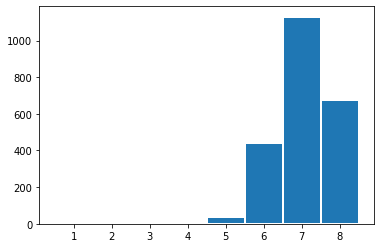

In [23]:
#Plot degree distribution
degrees = [y for x, y in H2.degree if x>0]
plt.hist(degrees, bins = [x - 0.5 for x in range(1,10,1)], edgecolor='white', linewidth=2)
plt.xticks(range(1,9))
plt.show()

We observe that all 8 users have approximately 700 of the anime in the network in their lists. Over 1000 anime are in 7 of the users' lists, and so on.

#### Network Depth

Let's now analyze the depth of the network starting from the root anime

In [25]:
base = [netmindeg_anime[0]] #Root (Anime or user node ID)

#Depth analysis variables
Ntotal = len(B.nodes)
foundset_N = 0
oldfoundset_N = 0
depth = 0
node_types = ["anime", "user"]

#Prepare dataframe to print
depth_df = pd.DataFrame(columns=["depth", "nodes", "visited", "new_nodes", "type"])

#Find the depth of the network from the root node
while foundset_N != Ntotal:
    foundset = {key for source in base for key in nx.single_source_shortest_path(B,source,cutoff=depth).keys()}
    foundset_N = len(foundset)
    depth_df.loc[depth] = \
        [depth, foundset_N, str(round(foundset_N/Ntotal*100,3))+"%", foundset_N-oldfoundset_N, node_types[depth%2]]
    oldfoundset_N = foundset_N
    depth = depth+1
    
print(depth_df)

  depth   nodes  visited new_nodes   type
0     0       1     0.0%         1  anime
1     1       9   0.003%         8   user
2     2    2300   0.828%      2291  anime
3     3  277831  99.999%    275531   user
4     4  277833   100.0%         2  anime


The network only has a depth of 4 starting from the root anime. After depth 2 all anime except 2 were found. The next search (depth 3) naturally found all users and at depth 4 all nodes had been visited. Naturally the depth of the network would be quite "shallow" as some users have almost all anime in their lists. Naturally, the next search will then include most users. 

### Degree Distribution

#### Anime

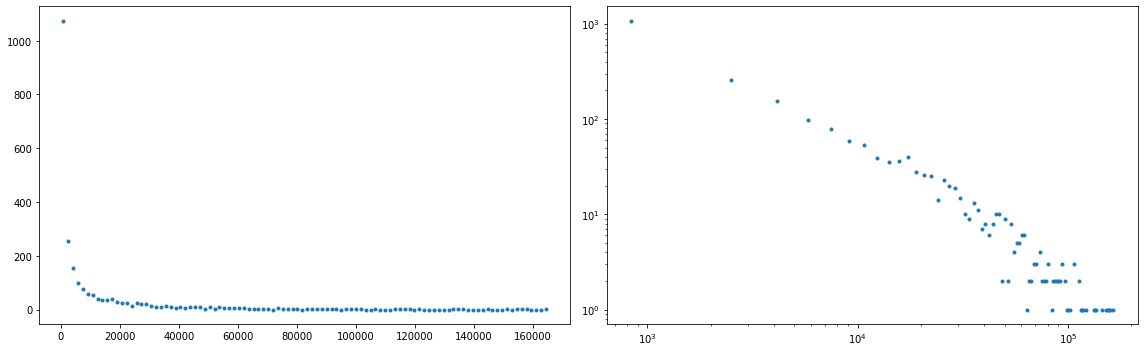

In [26]:
#Get a list of degrees for anime
degrees_anime = [y for x, y in B.degree if x>0]

#Make histogram with 100 bins
n, bins, patches = plt.hist(degrees_anime, bins=100) 
plt.close()
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

#Plot the degree distribution
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.scatter(bins_mean, n, marker=".")

ax2 = fig.add_subplot(122)
ax2.loglog(bins_mean, n, '.')

fig.tight_layout()
plt.show()

It is observed that most anime have a very low degree (are in many peoples' lists). The distribution follows a power law!

Let's take a look at the counts of the first three binned anime groups:

In [38]:
print("Anime with degrees between: " + str(bins[0]) + " and " + str(bins[1]) + " - " + str(int(n[0])))
print("Anime with degrees between: " + str(bins[1]) + " and " + str(bins[2]) + " - " + str(int(n[1])))
print("Anime with degrees between: " + str(bins[2]) + " and " + str(bins[3]) + " - " + str(int(n[2])))

Anime with degrees between: 8.0 and 1660.25 - 1074
Anime with degrees between: 1660.25 and 3312.5 - 256
Anime with degrees between: 3312.5 and 4964.75 - 156


And those three bins summed:

In [39]:
print("Anime with degrees between: " + str(bins[0]) + " and " + str(bins[3]) + " - " + str(int(sum(n[0:3]))))

Anime with degrees between: 8.0 and 4964.75 - 1486


1486 out of 2294 (over half of) anime are only in 8 to 4964 users' lists. Quite a low number considering there are 275.539 users in the network.

Now let's take a look at the user degree distribution

#### Users

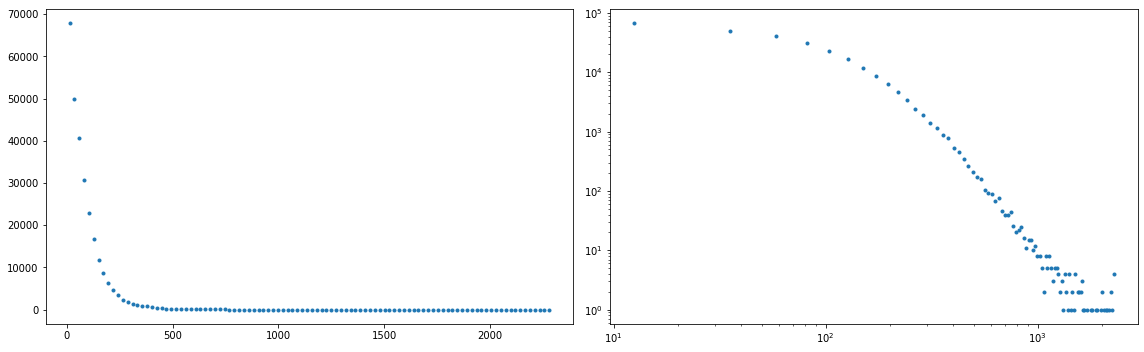

In [40]:
#Get a list of degrees for users
degrees_users = [y for x, y in B.degree if x<0]

#Calculate bins
n, bins, patches = plt.hist(degrees_users, bins=100) 
plt.close()
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

#Plot degree distribution
fig = plt.figure(figsize=(16,5))

ax1 = fig.add_subplot(121)
ax1.scatter(bins_mean, n, marker=".")

ax2 = fig.add_subplot(122)
ax2.loglog(bins_mean, n, '.')

fig.tight_layout()
plt.show()

This distribution also follows a power law! 

It is observed that very few users have over 250 anime in their lists. Let us check the binned data to check this theory:

In [45]:
print("Users with degrees between: " + str(bins[0]) + " and " + str(bins[11]) + " - " + str(int(sum(n[0:11]))))

Users with degrees between: 1.0 and 253.01 - 264035


264035 out of 275539 (over 95%) users have under 253 anime in their lists. This means that only 11.504 (under 5% of) users have over 250 (drama) anime in their lists

Let's take a look at the counts of the first three binned user groups:

In [60]:
print("Users with degrees between: " + str(bins[0]) + " and " + str(bins[1]) + " - " + str(int(n[0])))
print("Users with degrees between: " + str(bins[1]) + " and " + str(bins[2]) + " - " + str(int(n[1])))
print("Users with degrees between: " + str(bins[2]) + " and " + str(bins[3]) + " - " + str(int(n[2])))

Users with degrees between: 1.0 and 23.91 - 67929
Users with degrees between: 23.91 and 46.82 - 49972
Users with degrees between: 46.82 and 69.73 - 40610


And those three bins summed:

In [59]:
print("Users with degrees between: " + str(bins[0]) + " and " + str(bins[3]) + " - " + str(int(sum(n[0:3]))))

Users with degrees between: 1.0 and 69.73 - 158511


158511 out of 275539 (over half of) users have under 69 anime in their lists.

We are now done with looking at network statistics and will move on to more advanced analysis tools

# Tools, theory and analysis. Describe the process of theory to insight

## Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.

There are mainly three different network science tools / data analysis strategies used in this project:

The general ideas and the tools used will be explained in further detail in their respective sections. 

### 1. Attribute correlation with popularity

The idea here is to look at how different anime attributes (such as date it was released, score, etc.) and see how these correlate with how many users have the anime in their lists (the number of members). 

This will give a better picture of what makes an anime popular in the MAL community.


### 2. Community detection in the network of users who use tags

In terms of network science tools, this project mostly focused on community detection. 

The problem here is that this is a bipartite network. When detecting communities in a multipartite network, the graphs are usually reduced to a unipartite network by projection [[1]](https://arxiv.org/pdf/0906.0612.pdf) (page 8). There are two problems with doing this with the current network however:

1. Projecting the network onto the anime nodes would result in an ALMOST complete graph where it would be pointless to try and detect communities. This is because the top 10 users have 90%-99,999% of drama anime in their lists each (I'm talking about you *purplepinapples* with your 2292 out of 2294 Drama anime in your lists)

2. Projection is a very memory intensive process. Projecting the graph as is is close to impossible with my current hardware.

The number of links needs to be reduced (preferrably to somewhere around a few hundred thousand). The new (somewhat arbitraty) requirements for a user to link to an anime link are:

1. The user must have added a tag to the anime
2. The tag should be at least 3 letters long
3. There should be at least 10 of those tags in the network. 
4. The user must be female

These requiremts result in $129.181$ links. 


Hence, this is a network of users who have provided a Female gender to their profile and provided *meaningful* tags to anime they have in their lists. Two users are connected if they have tagged the same anime.

The idea is then to find meaningful communities of users who tag anime and find out what kinds of tags users in each community provide to the MAL platform.

### 3. Sentiment Analysis on reviews

This section will focus on finding the happiness/negativeness in the top 20 reviews of all anime. It will be analyzed how sentiments change depending on different attributes such as when the review was written, the score of the review, the average score of the anime etc.

This will give a better picture of how review sentiments change depending on different parameters.


## Talk about how you've worked with text, including regular expressions, unicode, etc.

The Kaggle dataset was very clean to begin with. When loading the anime dataframe, some attributes needed to be processed using the regular expressions strip and split (the lists were in string format and needed to be segmented). In the userlists dataframe, only the tags were particularly troublesome as users have entered whatever they wanted. First, all letters were converted to lower using lower(). Then, every symbol was checked and if the symbol was not a letter or a space (" ") it was not not kept. All letters and spaces are now in a list. join() was used to join all the letters and spaces and the resulting tag was tokenized using word_tokenize.

As mentioned, the content of the reviews was very clean. The only symbols that needed to be removed were newline and carriage return and common ones such as comma and "?". The words were tokenized, converted to lower case and stop words were removed.

If additional text cleaning tools have been used it will be explained in the section where they were used.

##  1. Attribute correlation with popularity

### The idea

The idea is to see what makes an anime popular with MAL users by looking at correlations between popularity and attributes such as airing date, review score etc. This will give a better picture of what kind of anime MAL users tend to watch.

### The tool

Generally only python structures such as lists and dictionaries were used. Additionally some regular expressions were used to clean some of the anime dictionary attributes. 

### The code

Let us start off by loading the relevant attributes from the userlists dataframe and anime dictionary (as well as degrees) and use regular expressions to process them where appropriate. 

In [158]:
#Define dataframe
anime_att_df = pd.DataFrame(columns = ["anime_id", "members", "type", "source", "episodes", "aired", "score", "scored_by", \
                                          "favourites", "producer", "licensor", "studio", "genre"])
#Add data using dictionary
no_anime = []
for node in dict_anime.keys():
    try:
        n=dict_anime[node]
        anime_att_df.loc[node] = [node, n.members, n.type, n.source, n.episodes, n.aired.split("'")[3], \
                                  n.score, n.scored_by, n.favorites, n.producer.strip(" ").split(","), \
                                  n.licensor.strip(" ").split(","), n.studio.strip(" ").split(","), \
                                  n.genre.strip(" ").split(",")]
    except:
        no_anime.append(node)

The data is plotted:

### Continuous Attributes

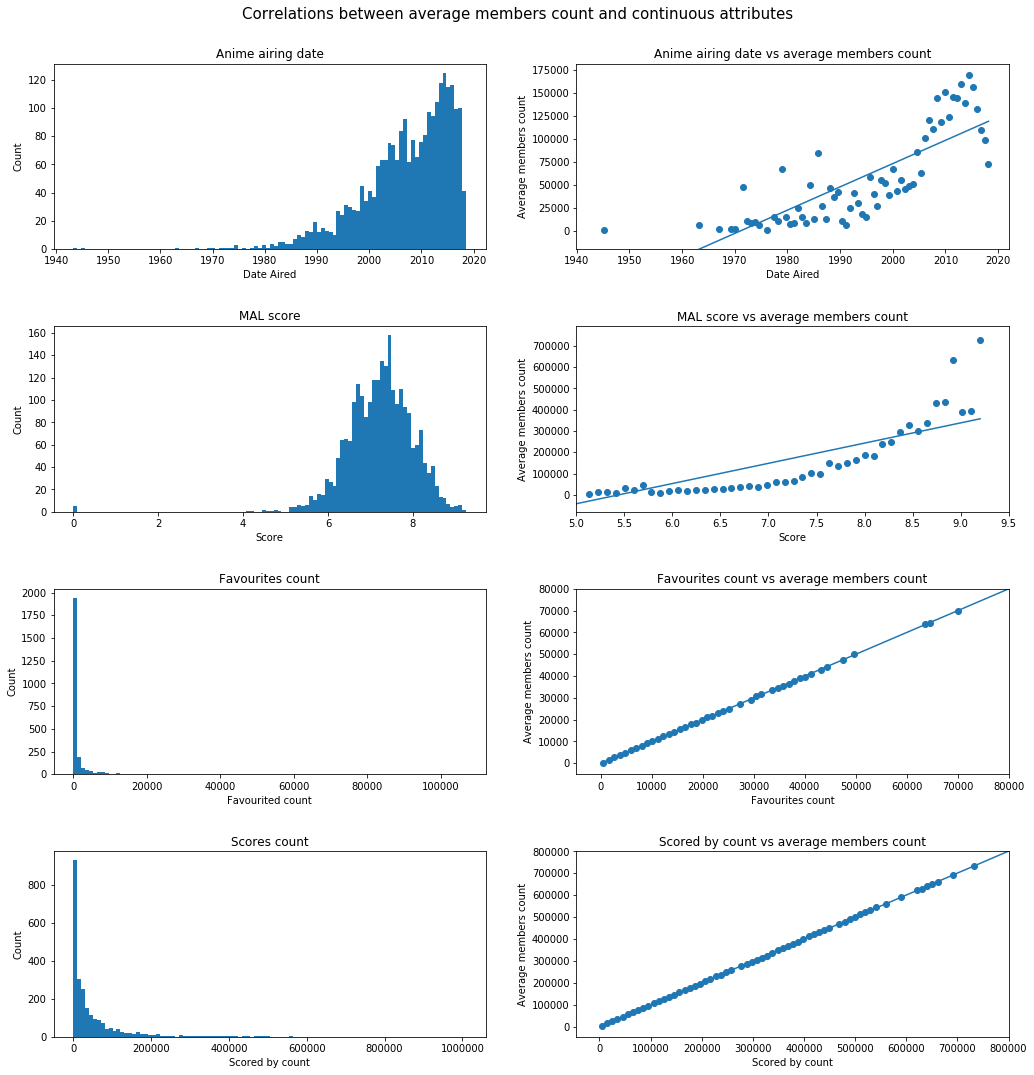

In [148]:
#ATTRIBUTE PLOTS

fig = plt.figure(figsize=(15,15));

##### DATES #####

#Date Plots
dates_df = anime_att_df[anime_att_df.aired !='to']
dates_df["dates"] = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_df.aired]

#Draw Date Histogram
ax1 = fig.add_subplot(421)
n, bins, patches = ax1.hist(dates_df.dates, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
dates_series = pd.Series(dates.date2num(dates_df.dates))

ax1.set(xlabel = "Date Aired", ylabel="Count", title="Anime airing date")

#Calculate Average members
datemeans = []
for i in range(len(bins)-1):
    datemeans.append(np.mean(dates_df.members[ list((dates_series>bins[i]) & (dates_series<bins[i+1]) )]) )

#Draw Date vs Avg members Scatter Plot 
ax2 = fig.add_subplot(422)
ax2.scatter(dates.num2date(bins_mean), datemeans)

#Draw Tendency Line
idx = np.isnan(datemeans);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(datemeans)[~idx]), 1)
ax2.plot(dates.num2date(bins_mean), b+[i * m for i in bins_mean], "-")

ax2.set(xlabel = "Date Aired", ylabel="Average members count", title="Anime airing date vs average members count",\
        ylim=[-20000, None])


##### SCORES #####

#Draw Score Histogram
ax1 = fig.add_subplot(423)
n, bins, patches = ax1.hist(anime_att_df.score, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

ax1.set(xlabel = "Score", ylabel="Count", title="MAL score")


#Calculate Average members
scoremeans = []
for i in range(len(bins)-1):
    scoremeans.append(np.mean(anime_att_df.members[ list((anime_att_df.score>bins[i]) & (anime_att_df.score<bins[i+1]) )]) )

#Draw Score vs Avg members Scatter Plot 
ax2 = fig.add_subplot(424)
ax2.scatter(bins_mean, scoremeans)

#Draw Tendency Line
idx = np.isnan(scoremeans);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(scoremeans)[~idx]), 1)
ax2.plot(bins_mean, b+[i * m for i in bins_mean], "-")

ax2.set(xlim=[5, 9.5],ylim=[-80000, None])

ax2.set(xlabel = "Score", ylabel="Average members count", title="MAL score vs average members count")


##### FAVOURITES #####

#Draw Favourites Histogram
ax1 = fig.add_subplot(425)
n, bins, patches = ax1.hist(anime_att_df.favourites, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

ax1.set(xlabel = "Favourited count", ylabel="Count", title="Favourites count")


#Calculate Average members
favmeans = []
for i in range(len(bins)-1):
    favmeans.append(np.mean(anime_att_df.favourites[ \
                        list((anime_att_df.favourites>bins[i]) & (anime_att_df.favourites<bins[i+1]) )]) )

#Draw Favourites vs Avg members Scatter Plot 
ax2 = fig.add_subplot(426)
ax2.scatter(bins_mean, favmeans)

#Draw Tendency Line
idx = np.isnan(favmeans);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(favmeans)[~idx]), 1)
ax2.plot(bins_mean, b+[i * m for i in bins_mean], "-")

ax2.set(xlim=[None, 80000],ylim=[None, 80000])

ax2.set(xlabel = "Favourites count", ylabel="Average members count", title="Favourites count vs average members count")

##### SCORED-BY #####

#Draw scored_by Histogram
ax1 = fig.add_subplot(427)
n, bins, patches = ax1.hist(anime_att_df.scored_by, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]

ax1.set(xlabel = "Scored by count", ylabel="Count", title="Scores count")

#Calculate Average members
scored_bymeans = []
for i in range(len(bins)-1):
    scored_bymeans.append(np.mean(anime_att_df.scored_by[ \
                        list((anime_att_df.scored_by>bins[i]) & (anime_att_df.scored_by<bins[i+1]) )]) )

#Draw Scored by vs Avg members Scatter Plot 
ax2 = fig.add_subplot(428)
ax2.scatter(bins_mean, scored_bymeans)

#Draw Tendency Line
idx = np.isnan(scored_bymeans);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(scored_bymeans)[~idx]), 1)
ax2.plot(bins_mean, b+[i * m for i in bins_mean], "-")

ax2.set(xlim=[None, 800000],ylim=[None, 800000])

ax2.set(xlabel = "Scored by count", ylabel="Average members count", title="Scored by count vs average members count")


fig.suptitle("Correlations between average members count and continuous attributes", y=1.01, fontsize=15)

#Show Plot
fig.tight_layout(pad=3.0)
plt.show()

The number of favourites an anime has and the number of people who have given an anime a score seem to be almost fully correlated with it's members. 

More interesting is the airing date and the MAL score. 

Popularity of an anime seems to rise exponentially with it's airing date. New anime (released within the latest 5 years) tend to have a lower members count, likely because they have yet to gain popularity.

The members also seems to rise exponentially with the score an anime has gotten.


### Next are the categorial attributes

Let's start with the studios who were responsible for making the anime

#### Studios

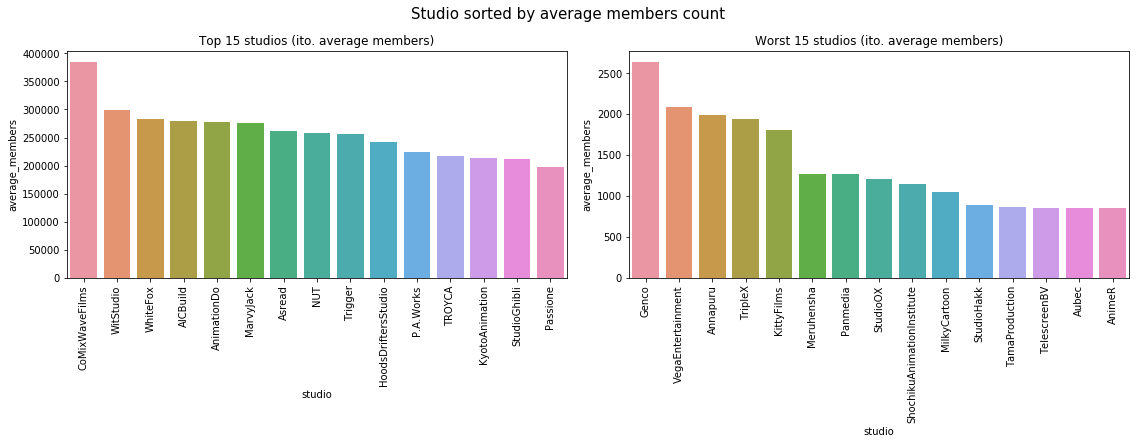

In [160]:
studios = list(set(["".join(item.split()) for sublist in list(anime_att_df.studio) for item in sublist]))

studio_mean_members = []

for s in studios:
    studio_in = []
    for i in anime_att_df.studio:
        studio_in.append(s in  "".join(''.join(i).split()))
    studio_mean_members.append(np.mean(anime_att_df.members[studio_in]))

studio_df = pd.DataFrame({"studio": studios, "average_members": studio_mean_members}).sort_values(by=['average_members'], \
                                                                                          ascending=False)
fig = plt.figure(figsize=(16,6));

ax1 = fig.add_subplot(121)
sns.barplot(data=studio_df[0:15], x="studio", y="average_members")
ax1.set(title="Top 15 studios (ito. average members)")
plt.xticks(rotation=90)


ax1 = fig.add_subplot(122)
sns.barplot(data=studio_df[-15:], x="studio", y="average_members")
ax1.set(title="Worst 15 studios (ito. average members)")
plt.xticks(rotation=90)

fig.suptitle("Studio sorted by average members count", y=1.03, fontsize =15)
fig.tight_layout(pad=1.5)
plt.show()

CoMixWaverFilms is the studio with the highest average members count. They produced critically acclaimed anime such as *Kimi no Na wa.* and *Tenki no Ko*.

Whitefox has produced very popular anime such as *Steins Gate*, *Re:Zero kara Hajimeru Isekai Seikatsu* and *Akame ga Kill!*

#### Sources (adaptations)

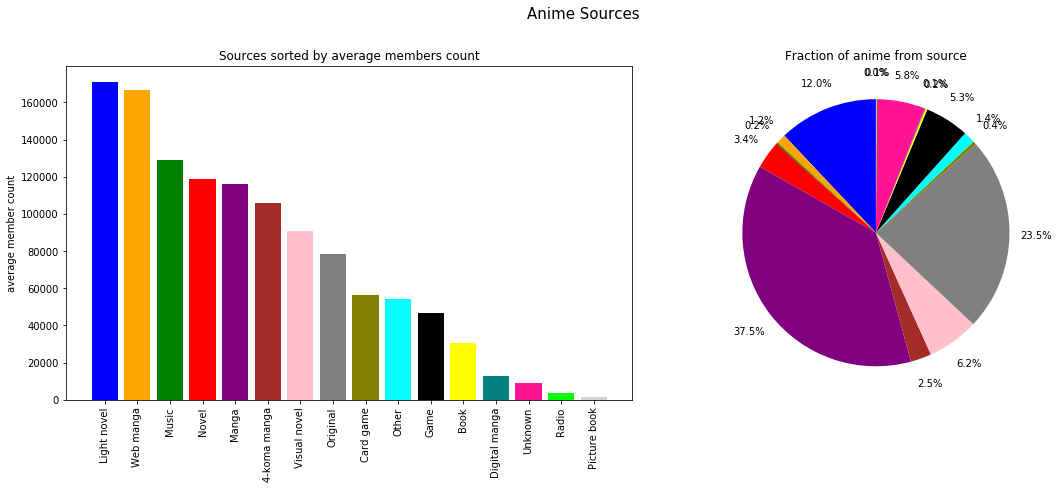

In [219]:
sources = list(set(anime_att_df.source))

sources_mean_degree = []

for s in sources:
    sources_mean_degree.append(np.mean(anime_att_df.members[anime_att_df["source"].str.contains(s)]))

sources_df = pd.DataFrame({"source": sources, "average_members": sources_mean_degree}).sort_values(by=['average_members'], \
                                                                ascending=False)


fig = plt.figure(figsize=(16,6));
palette =  ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', "gray", "olive", "cyan", "k", "yellow", "teal"\
           , "deeppink", "lime", "lightgray"]


ax1 = fig.add_subplot(121)
plt.bar(sources_df.source, height=sources_df.average_members, color= palette)
ax1.set(title="Sources sorted by average members count", ylabel="average member count")
plt.xticks(rotation=90)


gender_count = []

n=0
for i in sources_df.source:
    gender_count.append(len(anime_att_df[anime_att_df["source"]==i]))


ax1 = fig.add_subplot(122)
ax1.pie(gender_count, autopct='%1.1f%%', pctdistance=1.2 , shadow=False, startangle=90, labels=None,  colors=palette)

ax1.set(title="Fraction of anime from source")


fig.suptitle("Anime Sources", y=1.1, fontsize =15)
fig.tight_layout(pad=0)
plt.show()

Anime adapted from light novels seem to be the most popular on average. 12% of all anime on MAL are adapted from light novels.

1.2% of all anime on MAL are adapted from web manga. Most of them are almost as popular as light novels on average.

It's interesting to see that anime adapted from manga are that much less popular than light novels and web manga despite 37.5% of all anime being adapted from them. 

Likewise with anime that are original (not an adaptation) that constitutes 23.5% of all anime. Perhaps this is because anime adapted from other sources already have an audience. 

#### Type

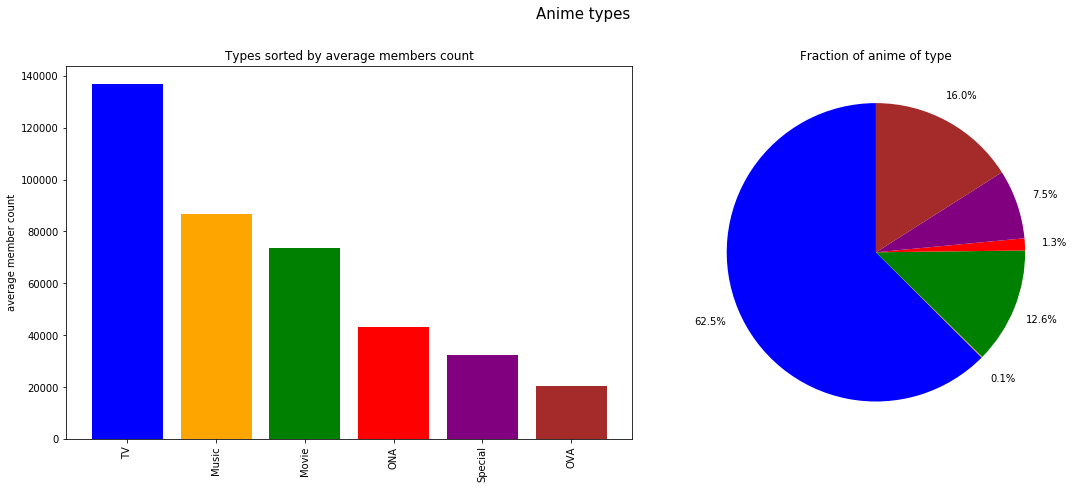

In [249]:
types = list(set(anime_att_df.type))

types_mean_degree = []

for s in types:
    types_mean_degree.append(np.mean(anime_att_df.members[anime_att_df["type"].str.contains(s)]))

types_df = pd.DataFrame({"type": types, "average_members": types_mean_degree}).sort_values(by=['average_members'], \
                                                                ascending=False)


fig = plt.figure(figsize=(16,6));
palette =  ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', "gray", "olive", "cyan", "k", "yellow", "teal"\
           , "deeppink", "lime", "lightgray"]


ax1 = fig.add_subplot(121)
plt.bar(types_df.type, height=types_df.average_members, color= palette)
ax1.set(title="Types sorted by average members count", ylabel="average member count")
plt.xticks(rotation=90)


gender_count = []

n=0
for i in types_df.type:
    gender_count.append(len(anime_att_df[anime_att_df["type"]==i]))


ax1 = fig.add_subplot(122)
ax1.pie(gender_count, autopct='%1.1f%%', pctdistance=1.2 , shadow=False, startangle=90, labels=None,  colors=palette)

ax1.set(title="Fraction of anime of type")


fig.suptitle("Anime types", y=1.1, fontsize =15)
fig.tight_layout(pad=0)
plt.show()

Anime series (TV) seem to be not only what constitues most of all anime but are also the most popular with MAL users

Music is the next most popular type of anime despite only constituting 0.1% of anime.

MAL users do not seem to have that many OVAs and specials in their anime lists. Perhaps because they are adaptations of original anime or movies they already have in their lists.


#### Genre

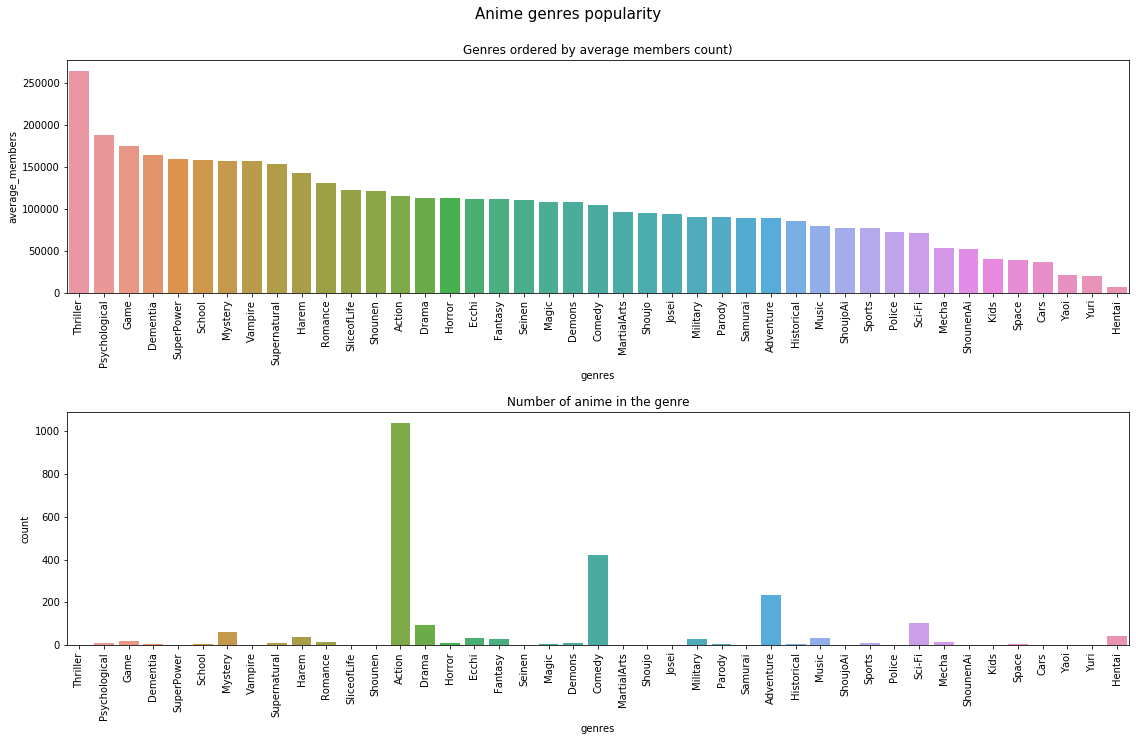

In [248]:
genres = list(set(["".join(item.split()) for sublist in list(anime_att_df.genre) for item in sublist]))

genres_mean_members = []

for s in genres:
    genres_in = []
    for i in anime_att_df.genre:
        genres_in.append(s in  "".join(''.join(i).split()))
    genres_mean_members.append(np.mean(anime_att_df.members[genres_in]))

genres_df = pd.DataFrame({"genres": genres, "average_members": genres_mean_members}).sort_values(by=['average_members'], \
                                                                                          ascending=False)



genres_count = []

for i in genres_df.genres:
    genres_count.append(len(anime_att_df[[i in s for s in anime_att_df["genre"]]]))


genres_df["count"] = genres_count


fig = plt.figure(figsize=(16,10));

ax1 = fig.add_subplot(211)
sns.barplot(data=genres_df, x="genres", y="average_members")
ax1.set(title="Genres ordered by average members count)")
plt.xticks(rotation=90)

ax1 = fig.add_subplot(212)
sns.barplot(data=genres_df, x="genres", y="count")
ax1.set(title="Number of anime in the genre")
plt.xticks(rotation=90)

fig.suptitle("Anime genres popularity", y=1.03, fontsize =15)
fig.tight_layout(pad=1.5)
plt.show()

It's interesting to see how anime in the Action genre are not that popular despite their abundance.

Thriller constitues a very small fraction of anime despite being very popular with MAL users.

### Outcome:

The following tendensies were observed:

- Popularity tend to rise exponentially with airing date (except anime released withing the last 5 years that likely have yet to gain popularity)
- Popularity rises exponentially with the MAL score
- CoMixWaverFilms's anime are the most popular on average by a large margin
- Anime adapted from light novels and web manga tend to be more popular than original anime and anime adapted from manga (that together constitute over 60% of all anime)
- Anime series tend to be more popular than anime movies
- There is untapped potential in genres such as thriller and psychological. The amount of anime in these genres is scarce despite their popularity.




## 2. Community detection in the network of users who use tags

### The idea

As mentioned the network is too big to project. Because of this it is necessary to redefine what links are. A few hundred thousand links would be a reasonable size to project. The new requirements for there to be a link between a user and an anime are:

- The user must have added a tag to the anime
- The tag should be at least 3 letters long
- There should be at least 10 of those tags in the network. 
- The user must be female

These requiremts result in $129.181$ links. 

The idea is then to look at the (projected) network of users who add *meaningful* tags to anime and see if it is possible to separate users into meaningful communities. This will hopefully reveal different kinds of tag-adding-users and what tags they add to anime.

### The tool

The Louvain algorithm was used for community detection in the projected graph. The Louvain algorithm will find the best partition of a network using a greedy optimization method. The resulting partitions are the communities.

The giant from the network will be used so that very small communities do not mess up the TF-IDF calculations.

For calculating how important a word is, the numerical statistic TF-IDF was calculated and used as weighting factor.

It was calculated like so:

The Term Frequency (TF) was calculated with the formula $tf_{i,j}=\frac{n_{i,j}}{{\sum_k n_{i,j}}}$ *where $n_{i,j}$ is the number of times a word $i$ has appeared in the document $j$ and $\sum_k n_{i,j}$ is the number of words $i$ in the document $j$*

The term frequency is multiplied by 10 million so that TF-IDF weights are not rounded to zero.

The Inverse Data Frequency (IDF) was calculated with the formula $log(\frac{N}{df_i})$ *where $N$ is the total number of documents, and $df_i$ is the number of documents containing the word $i$*

The TF and IDF values are then multiplied: $w_{i,j} = tf_{i,j}*log(\frac{N}{df_i})$

### The code

Let's start off by removing the rows from the userlists that do not fullfil the requirements for a link. Tags are cleaned and tokenized using join, word_tokenize. isalpha and stopwords are used to remove unwanted symbols.

In [441]:
#Require there to be at least # tags
atleast_ntags = 10

#Open userlist dataframe and remove Null rows
nodes_anime = pd.read_pickle("df_userlists.pkl")[["user_id", "anime_id", "my_status", "my_tags"]]
nodes_anime_df = nodes_anime[~nodes_anime['my_tags'].isnull()]
nodes_anime_df = nodes_anime_df[nodes_anime_df['my_status']==2]
gender_members = [x for x in set(nodes_anime_df.user_id) if dict_users[x].gender in ["Female"]]

nodes_anime_df = nodes_anime_df[nodes_anime_df["user_id"].isin(gender_members)]

#del nodes_anime
toRemove = nltk.corpus.stopwords.words('english') 

#Clean up the tags from the dataframe
new_tags= []
for tags in nodes_anime_df.my_tags:
    
    new_tags.append(word_tokenize(''.join([i for i in tags.lower() if i.isalpha() or i==" "])))    

#Add tags to dataframe and remove rows with empty tag lists
nodes_anime_df["tags"] = new_tags
nodes_anime_df = nodes_anime_df[["user_id","anime_id","tags"]][nodes_anime_df['tags'].map(lambda d: len(d)) > 3]

#Require at least # tags
grouped_tags = [item for sublist in nodes_anime_df.tags for item in sublist]
grouped_tags = pd.DataFrame({"tags": grouped_tags}).groupby(['tags']).size()
grouped_tags = grouped_tags.to_frame(name = 'size').reset_index()
grouped_tags = grouped_tags[grouped_tags["size"] >atleast_ntags]
grouped_tags = list(grouped_tags.sort_values(by="size", ascending=False).tags)

isin_grouped_tags = []
for tl in nodes_anime_df.tags:
    isin_grouped_tags.append(any(item in grouped_tags for item in tl))

nodes_anime_df = nodes_anime_df[isin_grouped_tags]
nodes_anime_df = nodes_anime_df[~nodes_anime_df['tags'].isnull()]

Populate the network with the new links

In [442]:
edges_all = list(zip(nodes_anime_df.anime_id, -nodes_anime_df.user_id))
nodes_anime = sorted(list(set(nodes_anime_df.anime_id)))
nodes_users = sorted(list(set(-nodes_anime_df.user_id)), reverse=True)

Btag = nx.Graph()

print("Network populating status:")
Btag.add_nodes_from(nodes_anime, bipartite=0); nodes_anime = None; print("Anime nodes added")
Btag.add_nodes_from(nodes_users, bipartite=1); nodes_users = None; print("User nodes added")
Btag.add_edges_from(edges_all); edges_all = None; print("All edges added")
print("Network was successfully populated and is ready to be analyzed")

Network populating status:
Anime nodes added
User nodes added
All edges added
Network was successfully populated and is ready to be analyzed


Extract the giant:

In [546]:
giant = max(nx.connected_component_subgraphs(Btag), key=len)

Now let us look at some stats:

In [547]:
nfo1, nfo2 = network_info(giant); print(nfo1)

      N  N_Anime  N_Users       L  Components  Largest_Component  k_min  \
0  9757     1587     8170  129179           1               9757      1   

   k_max  k_median     k_mean         p  
0   1203       7.0  26.479246  0.002714  


There are now $1587$ anime in the network, $8170$ users and $129179$ links between them. There is $1$ component.

The resulting graph is projected onto user nodes using networkx's inbuilt function and communities are found:

#### Project the graph onto user nodes

In [548]:
BtagProj = bipartite.projected_graph(giant, [x for x in giant.nodes if x<0])

In [549]:
with open('Giant_tag_projection.pkl', 'wb') as handle:
    pickle.dump(BtagProj, handle)

#### Find Communities

In [ ]:
with open('Giant_tag_projection.pkl', 'rb') as handle: #Load partition
    BtagProj = pickle.load(handle)

In [550]:
#Find communities
partition = community_louvain.best_partition(BtagProj) #Takes long!!!

In [551]:
#Save partition to file
with open('community_partition_Giant.pkl', 'wb') as handle:
    pickle.dump(partition, handle)

#### Map user_ids onto the partition dataframe

In [392]:
#Open partition file in case it already exists
with open('community_partition_Giant.pkl', 'rb') as handle: #Load partition
    partition = pickle.load(handle)

In [552]:
#Add community attribute to dataframe so that we know which tags belongs to each community
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['community'])
partition_df["user_id"] = partition_df.index

if nodes_anime_df["user_id"].iloc[0] > 0:
    nodes_anime_df["user_id"] = [-x for x in nodes_anime_df.user_id]
    
partition_df = pd.merge(partition_df, nodes_anime_df, how="inner", on="user_id")

Now to count tag occurences in each community. Genres are removed from the tags as well as the word "anime".

In [553]:
#Minimum and maximum number of letters allowed in each word
minletters = 0
maxletters = 100

#Make list of lists same size as number of communities
CommunitiesWordCount = []
for i in set(partition_df.community):
    CommunitiesWordCount.append([])

#Add tags from anime in each community
community_words = []
for i in set(partition_df.community):
    community_words.append([item for sublist in partition_df[partition_df.community==i].tags \
                            for item in sublist if len(item)<=maxletters and len(item)>=minletters])

#Find all unique tags
allwords = set([item for sublist in partition_df.tags for item \
                in sublist if len(item)<=maxletters and len(item)>=minletters])

#Remove genres and the word "anime" from the tags
#genres_list = list(set([item for sublist in [dict_anime[g].genre.lower().split(", ") \
#                    for g in [x for x in dict_anime.keys()] if isinstance(dict_anime[g].genre, str)] for item in sublist]))
#genres_list = [item for sublist in [x.split(" ") for x in genres_list] for item in sublist]
#allwords = [t for t in [x for x in allwords if x not in genres_list] if t!="anime" and re.search('^[a-zA-Z]+$',t)]

#Count unique tags in each community
n=1
for word in allwords:
    #Count progress in %
    b = "Cell Status: Running - " + str(round(n/len(allwords)*100, 2)) +"% Until Completion         "
    print(b, end="\r")
    n+=1
    
    for i in range(len(community_words)):
        CommunitiesWordCount[i].append(community_words[i].count(word))

In [554]:
#Save community tag counts
with open('words_all_Giant.pkl', 'wb') as handle:
    pickle.dump(allwords, handle)
    
with open('words_count_Giant.pkl', 'wb') as handle:
    pickle.dump(CommunitiesWordCount, handle)
    
with open('words_community_Giant.pkl', 'wb') as handle:
    pickle.dump(community_words, handle)

#### Calculate TF-IDF

In [ ]:
#Open community tag counts
with open('words_all_Giant.pkl', 'rb') as handle:
    allwords = pickle.load(handle)

with open('words_count_Giant.pkl', 'rb') as handle:
    CommunitiesWordCount = pickle.load(handle)

with open('words_community_Giant.pkl', 'rb') as handle:
    community_words = pickle.load(handle)

TF-IDF is now calculated. As mentioned, the frequency is logged as very few tags occur extremely frequently in all communities.

In [558]:
#Prepare idf list
idf = [0]*len(CommunitiesWordCount[0])

#Count number of communites using each word
for i in range(len(CommunitiesWordCount)):
    idf+=np.where(np.array(CommunitiesWordCount[i]) == 0, 0, 1)

#Calculate idf
idf = [np.log(len(CommunitiesWordCount)/i) for i in idf]

#Calculate term frequency TF (divide by number of words in each document)
tf = [[] for x in range(0,len(CommunitiesWordCount))]
for i in range(len(CommunitiesWordCount)):
    tf[i]=[j/len(community_words[i])*1000000 for j in CommunitiesWordCount[i]]

#Calculate tf-idf
tfidf = []
for w in range(len(CommunitiesWordCount)):
    tfidf.append([int(round(i*j)) for i, j in zip(tf[w], idf)])

#### Plot wordclouds

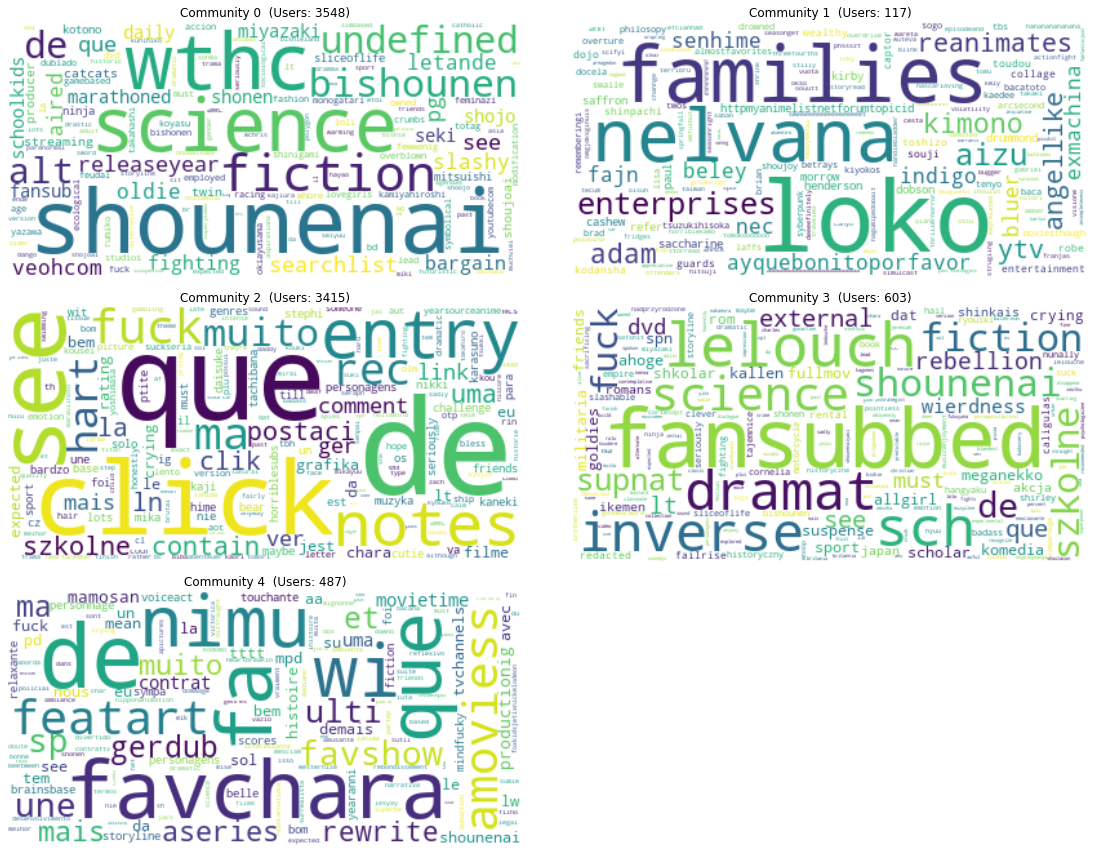

In [559]:
#Prepare word strings (for wordcloud parsing) for each community
WC_list = []
for i in range(0, len(CommunitiesWordCount)):
    WC_list.append( " ".join([(w + " ") * n for w, n in zip(allwords, tfidf[i])]) )

#Plot wordcloud
plt.figure(figsize=[16,12], tight_layout=True)

for i in range(0, len(CommunitiesWordCount)):
    wc = WordCloud(
        background_color="white", 
        max_words=200, contour_width=3, 
        contour_color='red', 
        collocations=False
        ).generate(WC_list[i])


    ax = plt.subplot(3, 2, i+1)
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    plt.title("Community "+str(i)+"  (Users: " + str(len([x for x in [partition[i] for i in partition if i<0] if x==i]))+")")

plt.show()

#### Outcome

5 communities were found. The number of users in each community can be seen on the respective wordclouds.

there are a lot of words that are not in english. These appear very frequently in specific communities. For example Community 0 and 3 is mostly english while community 2 seems to have a lot of Spanish and or Portuguese words. It's interesting to see that the community detection to some extent has separated users with different languages into separate communities!

Most of the tags in community 4 are unreadable but also seem to be populated by non-english speaking users.

There also seems to be a difference in what category of anime are tagged. For example in community 0 where shounenai (love between boys) and bishounen (beautiful boy) are frequent tags while community 3 seems to tag the anime Code Geass: lelouch of the rebellion a lot. Community 1 seems to be more wholesome than community 0 with frequent tags such as families, kimono and angellike.



## 3. Sentiment Analysis on reviews

### The idea:

Sentiments are measures of happiness/negativeness. 

This section focuses on finding sentiments for the top 20 reviews for all anime on MAL and testing how sentiments correlate with different attributes form both the review dataset and the anime dataset. For example, is there a difference in sentiments depending on what score the review gave the anime? Have sentiments changed over time?

### The tool:

Sentiments are calculated using the LabMT [wordlist](https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001). It consists of 10.000 words where each word's happiness/negativeness has been evaluated. The tokenized words and wordcounts have already been found in the review section so all that is missing is mapping the different sentiments to the words and get an average sentiment score.

### The code:

The wordlist is downloaded and converted into a dictionairy to quickly find words sentiments. 

A function is made that takes a list of tuples with a word and the wordcount and returns the resulting sentiment score

In [356]:
#Import sentiment word file and create a list of them
sentiment_file = requests.get(\
    'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001').text
reader = csv.reader(io.StringIO(sentiment_file), delimiter='\t')
sentiment_list_all = [l for l in reader][4:]

#Create a dictionary for the words and the weights
sentiment_dict = {}
for i in sentiment_list_all:
    sentiment_dict[i[0]] = float(i[2])

#Function that takes tokenized words and returns average sentiment
def calcSentiment(tokens):
    return  [item for sublist in [[sentiment_dict[t]]*c for t, c in tokens if t in sentiment_dict.keys()] for item in sublist] 

The reviews dataset is loaded, average sentiments for each review is calculated and addet to the reviews dataframe. There are now two new columns, one with the averaged review sentiment score and another with the number of words that had a sentiment score.

In [ ]:
new_reviews_csv = pd.read_csv("reviews2.csv")

nwords = []
sentiments = []
for wl, cl in zip(new_reviews_csv.words, new_reviews_csv.wordcount):
    t = zip(ast.literal_eval(wl), ast.literal_eval(cl))
    s = calcSentiment(t)
    sentiments.append(np.mean(s))
    nwords.append(len(s))

new_reviews_csv["sentiment_sum"] = sentiments
new_reviews_csv["num_of_words"] = nwords

The sentiments are plotted against the dates the reviews were written and the date the anime aired

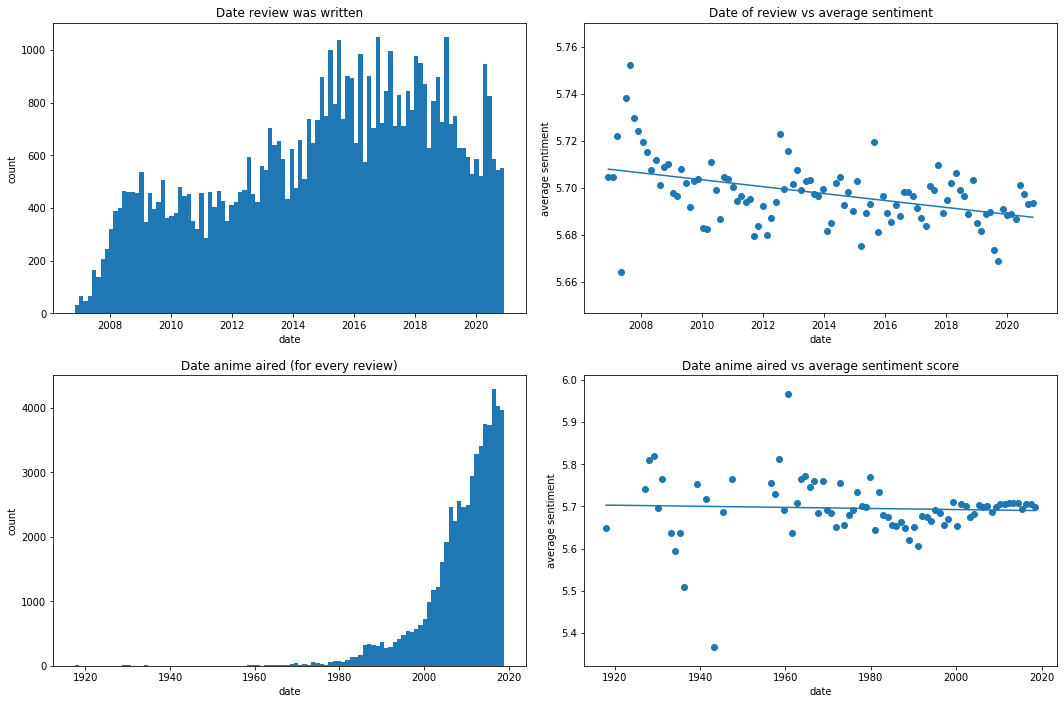

In [372]:
fig = plt.figure(figsize=(15,10));

##### REVIEW DATE #####

#Date Plots
dates_df = new_reviews_csv
dates_df["date"] = [dt.datetime.strptime(str(d),'%Y-%m-%d').date() for d in dates_df.date]

#Draw Date Histogram
ax1 = fig.add_subplot(221)
n, bins, patches = ax1.hist(dates_df.date, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
dates_series = pd.Series(dates.date2num(dates_df.date))

ax1.set(title="Date review was written", xlabel="date", ylabel="count")

#Calculate Average Sentiment
avg_sentiment = []
for i in range(len(bins)-1):
    avg_sentiment.append(np.mean(dates_df.sentiment_sum[list((dates_series>bins[i]) & (dates_series<bins[i+1]))]))

#Draw Date vs Avg Degree Scatter Plot 
ax2 = fig.add_subplot(222)
ax2.scatter(dates.num2date(bins_mean), avg_sentiment)

#Draw Tendency Line
idx = np.isnan(avg_sentiment);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(avg_sentiment)[~idx]), 1)
ax2.plot(dates.num2date(bins_mean), b+[i * m for i in bins_mean], "-")

ax2.set(title="Date of review vs average sentiment", xlabel="date", ylabel="average sentiment")


##### ANIME AIRED #####

dates_df = new_reviews_csv

aired_list = []
for i in dates_df.anime_id:
    aired_list.append(dict_anime[i].aired.split("'")[3])

dates_df["aired"] = aired_list
dates_df = dates_df[dates_df.aired !='to']
dates_df['aired'].apply(lambda x: pd.to_datetime(x))
    
#Date Plots
dates_df["aired"] = [dt.datetime.strptime(str(d),'%Y-%m-%d').date() for d in dates_df.aired]

#Draw Date Histogram
ax1 = fig.add_subplot(223)
n, bins, patches = ax1.hist(dates_df.aired, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
dates_series = pd.Series(dates.date2num(dates_df.aired))

ax1.set(title="Date anime aired (for every review)", xlabel="date", ylabel="count")

#Calculate Average Sentiment
avg_sentiment = []

for i in range(len(bins)-1):
    avg_sentiment.append(np.mean(dates_df.sentiment_sum[list((dates_series>bins[i]) & (dates_series<bins[i+1]))]))

#avg_sentiment = [i / j for i, j in zip(sentiment_sums, wordcount_sums)] 
    

#Draw Date vs Avg Degree Scatter Plot 
ax2 = fig.add_subplot(224)
ax2.scatter(dates.num2date(bins_mean), avg_sentiment)

ax2.set(title="Date anime aired vs average sentiment score", xlabel="date", ylabel="average sentiment")

#Draw Tendency Line
idx = np.isnan(avg_sentiment);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(avg_sentiment)[~idx]), 1)
ax2.plot(dates.num2date(bins_mean), b+[i * m for i in bins_mean], "-")

fig.tight_layout(pad=1.5)
plt.show()

The sentiments of reviews are generally becoming less happy over time.

Sentiments do not seem to change significantly depending on when the anime was released. There is a large sentiment variation before 2000 but this is likely due to scarcity of reviews.

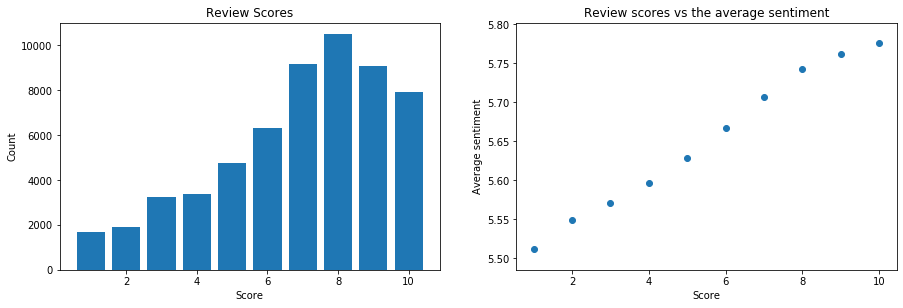

In [374]:
fig = plt.figure(figsize=(15,10));

##### REVIEW SCORE DATE #####

#Date Plots
dates_df = new_reviews_csv

scores_count = []

for i in range(1,11):
    scores_count.append(len(dates_df[dates_df.score==i]))

#Draw bar plot
ax1 = fig.add_subplot(221)
ax1.bar(list(range(1,11)), scores_count)
bins_mean = list(range(1,11))
dates_series = pd.Series(dates_df.score)

ax1.set(title="Review Scores", xlabel="Score", ylabel="Count")

#Calculate Average Sentiment
avg_sentiment = []
for i in range(1,11):
    avg_sentiment.append(np.mean(dates_df.sentiment_sum[dates_df.score==i]))


#Draw Score vs Avg Sentiment Scatter Plot 
ax2 = fig.add_subplot(222)
ax2.scatter(range(1,11), avg_sentiment)
ax2.set(title="Review scores vs the average sentiment", xlabel="Score", ylabel="Average sentiment" )

plt.show()

There is a clear relationship between review score and review sentiment (as was to be expected). The average sentiment difference between a review score of 1 and a review score of 10 is ~0.3, which is not much but the connection is quite clear. 

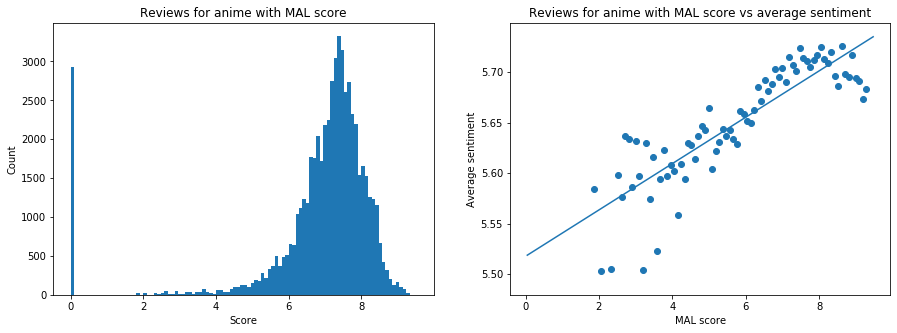

In [388]:
fig = plt.figure(figsize=(15,5));


##### REVIEW DATE #####

#Date Plots
dates_df = new_reviews_csv

# Add MAL scores
MALscore = []
for i in new_reviews_csv.anime_id:
    MALscore.append(dict_anime[i].score)
dates_df["MALscore"] = MALscore

#Draw Date Histogram
ax1 = fig.add_subplot(121)
n, bins, patches = ax1.hist(dates_df.MALscore, bins=100)
bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))]
dates_series = pd.Series(dates_df.MALscore)

ax1.set(title="Reviews for anime with MAL score", xlabel="Score", ylabel="Count")

#Calculate Average Sentiment
avg_sentiment = []
for i in range(len(bins)-1):
    avg_sentiment.append(np.mean(dates_df.sentiment_sum[list((dates_series>bins[i]) & (dates_series<bins[i+1]))]))

#Draw Date vs Avg Degree Scatter Plot 
ax2 = fig.add_subplot(122)
ax2.scatter(bins_mean, avg_sentiment)

#Draw Tendency Line
idx = np.isnan(avg_sentiment);
b, m = polyfit(list(pd.Series(bins_mean)[~idx]), list(pd.Series(avg_sentiment)[~idx]), 1)
ax2.plot(bins_mean, b+[i * m for i in bins_mean], "-")

ax2.set(title="Reviews for anime with MAL score vs average sentiment", xlabel="MAL score", ylabel="Average sentiment")

plt.show()

As with the review scores, there is a clear relationship between MAL score and the average sentiment. Anime that are generally disliked are more likely to have more negatively written reviews.


### Outcome 

The following tendencies were observed from the plots:

- Reviews are generally becoming more and more negative (but still above neutral sentiment 5)
- There is an almost fully correlated linear relationship between review scores and review sentiments. Even with reviews giving a score of 1 the average sentiment is still on the positive side though.
- In general, the worse the score (both review score and MAL score), the more negative the review sentiment is.
- Most of the top 20 reviews give a score of 8



### The happiest and the saddest reviews: 

In [545]:
new_reviews_csv.sort_values(by=['sentiment_sum'], ascending=False)

,anime_id,review_id,helpful_count,score,username,date,words,wordcount,sentiment_sum,num_of_words,aired,MALscore
9971,1117,69455,5,9,HazelOwers,2012-08-11,"['love', 'lugia', 'music', 'song', 'beautiful'...","[1, 1, 1, 1, 1, 1, 1, 1, 1]",7.285714,7,1999-07-17,7.45
7300,730,187079,29,10,rennygade,2015-05-03,"['outstanding', 'entertainment', 'family', 'be...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",6.898333,12,1994-04-09,5.22
23490,6219,78593,24,10,sakugaboygogogo,2012-11-28,"['miyazaki', 'grow', 'true', 'quality', 'beaut...","[1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",6.741818,11,2012-05-19,7.11
4890,415,13136,1,10,akina47,2009-03-12,"['love', 'super', 'loved', 'give', 'points', '...","[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...",6.702667,15,1999-07-17,7.32
10632,1250,64201,3,10,MorbidSoul,2012-06-23,"['great', 'tale', 'betrayl', 'think', 'good', ...","[1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, ...",6.680000,24,2005-04-05,7.39
...,...,...,...,...,...,...,...,...,...,...,...,...
4704,395,7645,9,4,Gangoke,2008-09-02,"['gantz', 'part', 'wanting', 'seen', 'characte...","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.670000,18,2004-08-26,7.22
5420,470,19279,2,5,Nejosh,2009-10-01,"['schon', 'ganz', 'sich', 'ger', 'tennis', 'au...","[1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, ...",4.645377,106,2005-07-02,6.42
4951,419,288040,1,4,municross,2018-09-03,"['dick', 'half', 'grabbing', 'formulasame', 'f...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.430638,47,2002-07-02,7.00
11059,1345,29416,7,1,aeris2001x2,2010-08-08,"['ever', 'away', 'worst', 'watch', 'never', 'a...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",4.202000,10,1991-02-22,3.19


#### The three happiest reviews:

The happiest review was made by **HazelOwers**, August 2012 about the anime movie **Pokemon Movie 02: Maboroshi no Pokemon Lugia Bakutan**:

"*This is my favourite pokemon movie :) i love lugia's song, beautiful music*" **(sentiment score: 7.29)**

The second happiest was made by **rennygade** in May 2015 about the anime **Houkago no Shokuinshitsu**:

*Truly this is an outstanding slice of entertainment.
Animation at it's best.
10/10.
This is quality.
Fun for the whole family.
Worth 54 minutes of my life.* **(sentiment score: 6.90)**


The third happiest was made by **sakugaboygogogo** Nov 2012 about the anime **Nijiiro Hotaru: Eien no Natsuyasumi**:

*masterpiece, beautiful in any aspects, can be compared to a Miyazaki quality film.
The design is very original,
story is beautiful and nostalgic, magical.
atmosphere is wonderful.
characters grow into my heart.
beauty, true beauty* **(sentiment score: 6.74)**

#### The three saddest reviews

The saddest review on the MAL platform was made by **aeris2001x2** August 2010 about the anime **Soujuu Senshi Psychic Wars**:

*This is without doubt the WORST anime i have ever seen.
Please never watch this, it will suck your soul away :(* **(sentiment score: 4.20)**

The second saddest was made by **municross** September 2018 about the anime **Samurai Deeper Kyou**:

*GARBAGE. The fight scene are repetitive and kyou has almost never lost a fight. Kyoshiro isnt even the MC its kyou. Kyoshiro is a WAYYYYYYYYYY BETTER character than kyou. Yuya , falls for kyou, despite him being an asshole op who doesnt deserve shit. Whilst kyoshiro (original mc) iv abandoned for half the manga and and is shit on. POOR BEsT BOI. Yuya is a hoe who secretly likes kyou grabbing her boobs and ass and only follows him to get that kyou dick. Back to the fight scenes here is the formula
same old attacks> kyou is almost losing and still is cocky> kyou wins* **(sentiment score: 4.43)**

The third saddest was made by **Nejosh** October 2009 about the anime **Okusama wa Joshikousei**:

*Eines ganz klar vorweg: Großes Tennis wird hier nicht geboten.
Es ist durchschnittlich. Etwas ecchi, aber nicht allzu sehr versaut, etwas Komödie, aber kein Dauerlacher, etwas Liebe, aber eben nicht die große.
Ein Mädchen, 17 und Oberschülerin, verheiratet mit dem Physik/Astronomie-Lehrer - rechtlich gesehen anscheinend durchaus legal in Japan, gesellschaftlich jedoch sehr wohl auch im Land der aufgehenden Sonne ein brisantes Thema.
Asami, so heißt das niedliche, etwas verschlossene Mädchen, ist vernarrt in ihren Ehemann, und will die Ehe deshalb um alles in der Welt geheim halten vor Freunden, Nachbarn, Lehrern, allen, genauso ihr Mann. Dies + die immer wieder auftauchenden Interessenten und Nebenbuhler um die zwei "Singles" + der Schwiegerpapa, der sexuelle Aktivität in der Ehe bis zum Schulabschluss der Tochter auf Händchenhalten vertraglich untersagt haben will = ergeben eine tragikomische Mischung, die in ihrer geladenen Spannung nur unterbrochen wird durch stille Momente der Zärtlichkeiten zwischem dem neuvermählten Paar.
Der Anime ist gut für Zwischendurch. Durch die Restriktion des Animes hinsichtlich des Ecchi-Gehalts im Gegensatz zum Manga, der unterm Strich eher ernsthafteren Stimmung der Serie und der Durchschnittlichkeit bzw. Alltäglichkeit der Charaktere und der Geschehnisse, können sogar Anlass geben, es als gute Familienunterhaltung fürs Nachmittagfernsehen durchgehen zu lassen.
Positiv: Fan-Service mit fast schon notgeilen Lehrerinnen und anzüglichen Nachbarinnen; ein unterhaltsames Tabu-Thema (junges Ding gibt "alles" für den lieben Ehemann); eine aufopfernde Liebesbeziehung, die von Treue viel hält.
Negativ: Sehr geringe Weiterentwicklung der Charaktere; viel versprechende Konstellationen und Situationen, dafür aber wenig Dargebotenes (ecchi!); monotone Ereignisabfolgen; und viel zu wenig Informationen über die Vorgeschichte.
Fazit: Ein durchschnittlicher Anime, der sich allenfalls durch Simplizität und Ehrlichkeit abzuheben versucht. Wer eine Vorlage für "schmutzige Fantasien" sucht, wird leer ausgehen. Alles in allem leichte Kost also: wohl bekomm's!* **(sentiment score: 4.64)**

# Discussion. Think critically about your creation

## What went well?

### Attribute analysis

It was interesting to visualize the different aspects that make an anime popular with the MAL community. For example how there are so few thriller anime despite being so popular with users. Or how anime adapted from light novels and web manga tend to be way more popular than original anime and anime adapted from manga. All in all I'd say that I achieved to show a lot of interesting insights on the dataset.

### Review sentiment

It was also interesting to see how review sentiments are actually getting more negative with time. Are people getting sadder? Is the general quality of anime going down? 

I think this project has generally revealed some interesting insights into the MAL platform and their users.

### Community detection

Female MAL users were separated into diferent communities where language and "wholesomeness" differed. Some communities mainly used non-english tags and others mostly english. Community 0 was especially unwholesome compared to the rest where tags about boys' love were frequent.


## What is still missing? What could be improved?, Why?

### Community detection

There was the problem of the network being too big for projection and I had to compromise a lot. It could be interesting to see how the whole network would be separated into communities and what tags they would use. 

### Additional remarks

It could be interesting to look at more attribute relationships. I think there is a lot of information still to be discovered in the data. For example attributes' relationship with scores. What usually makes a *good* anime.

I have created an anime recommendation system that takes a root anime and searches the network for what other users who watch that anime also watch. This could have been an interesting to include in the project in some way. 




## References

[[1] Fortunato, Santo: Community detection in graphs](https://arxiv.org/pdf/0906.0612.pdf) (2010)
